In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt
from collections import Counter
from pyliftover import LiftOver
from metaCH.src.utils import pr_curve, roc_curve, add_patient_level_features, seq_alter_to_endpos_vartype
from metaCH.src.utils import load_config
config = load_config()

benchmarking_data_path = config["path_info"]["benchmarking_data_path"]

## Load / preprocess external validation datasets

In [2]:
# -------------------- razavi
razavi_dataset=pd.read_excel(benchmarking_data_path+'scitranslmed.abm8729_data_file_s1.xlsx',\
                             sheet_name='Data_file_S1_MSKCC_annotated', engine='openpyxl')

razavi_dataset.rename(columns={'chromosome':'Chromosome',\
                                'reference_allele': 'Reference_Allele', 'alternate_allele': 'Tumor_Allele_1',\
                                'pos_start':'Start_Position','pos_end':'End_Position',\
                                'gene_name':'Gene_Name','gene_name':'Hugo_Symbol',\
                                'cfdna_af':'VAF'}, inplace=True)
razavi_dataset["Tumor_Allele_2"]=razavi_dataset["Tumor_Allele_1"]
razavi_dataset['Mut_nt']=razavi_dataset['variant'].apply(lambda x: x.split(':')[-1])
razavi_dataset[['Variant_Type','End_Position']] = razavi_dataset['Mut_nt'].astype(str).apply(seq_alter_to_endpos_vartype)
razavi_dataset['Start_Position']=razavi_dataset['variant'].apply(lambda x: x.split(':')[1])
razavi_dataset['End_Position']=razavi_dataset['Start_Position'].astype(int)+razavi_dataset['End_Position'].astype(int)
razavi_dataset['CANCER_TYPE']=razavi_dataset['tissue'].replace({'Breast':'Breast Cancer',\
                                  'Lung':'Non-Small Cell Lung Cancer', 'Prostate':'Prostate Cancer'})
razavi_dataset["Reference_Genome"]= "GRCh37"
razavi_dataset["label"]=razavi_dataset["bio_source"].replace({'wbc_matched':'Blood', 'biopsy_matched':'Tumor'})
razavi_dataset["Sample_ID"]=razavi_dataset["sample_ID"]


razavi_dataset = razavi_dataset[razavi_dataset['label'].isin(['Blood','Tumor'])].reset_index(drop=True)

N_blood=razavi_dataset[razavi_dataset['label']=='Blood'].shape[0]
N_tumor=razavi_dataset[razavi_dataset['label']=='Tumor'].shape[0]

print('razavi_dataset shape', razavi_dataset.shape,\
      'Genes(N):',razavi_dataset.Hugo_Symbol.unique().shape[0],\
      'Variants(N):',razavi_dataset.variant.unique().shape[0],\
      'Blood/Tumor (N):', N_blood,N_tumor,\
      'Blood- derived variant %:',np.round((N_blood/N_tumor)*100,1),\
     )

# -------------------- leal
leal_dataset=pd.read_excel(benchmarking_data_path+'scitranslmed.abm8729_data_file_s3.xlsx',\
                             sheet_name='Leal_et_al_predictions', engine='openpyxl')

leal_dataset.rename(columns={'chromosome':'Chromosome',\
                                'reference_allele': 'Reference_Allele', 'alternate_allele': 'Tumor_Allele_1',\
                                'pos_start':'Start_Position','pos_end':'End_Position',\
                                'X4':'Variant_Type',\
                                'gene_name':'Gene_Name',\
                                'Mutant.Allele.Fraction':'VAF'}, inplace=True)
leal_dataset["Tumor_Allele_2"]=leal_dataset["Tumor_Allele_1"]
leal_dataset["Hugo_Symbol"]=leal_dataset["Gene_Name"]
leal_dataset['Mut_nt']=leal_dataset['variant'].apply(lambda x: x.split(':')[-1])
leal_dataset[['Variant_Type','End_Position']] = leal_dataset['Mut_nt'].astype(str).apply(seq_alter_to_endpos_vartype)
leal_dataset['Start_Position']=leal_dataset['variant'].apply(lambda x: x.split(':')[1])
leal_dataset['End_Position']=leal_dataset['Start_Position'].astype(int)+leal_dataset['End_Position'].astype(int)
# leal_dataset["CANCER_TYPE"]="gastric cancer"
leal_dataset["CANCER_TYPE"]="Gastrointestinal Stromal Tumor"
leal_dataset["Reference_Genome"]= "GRCh37"
leal_dataset["label"]=leal_dataset["Origin"].replace({'CHIP':'Blood', 'ctDNA':'Tumor'})
leal_dataset["Sample_ID"]=leal_dataset["Patient.Timepoint"]


N_blood=leal_dataset[leal_dataset['label']=='Blood'].shape[0]
N_tumor=leal_dataset[leal_dataset['label']=='Tumor'].shape[0]

print('leal_dataset shape', leal_dataset.shape,\
      'Genes(N):',leal_dataset.Hugo_Symbol.unique().shape[0],\
      'Variants(N):',leal_dataset.variant.unique().shape[0],\
      'Blood/Tumor (N):', N_blood,N_tumor,\
      'Blood- derived variant %:',np.round((N_blood/N_tumor)*100,1),\
     )

# -------------------- Chabon
chabon_dataset=pd.read_excel(benchmarking_data_path+'scitranslmed.abm8729_data_file_s3.xlsx',\
                             sheet_name='Chabon_et_al_predictions', engine='openpyxl')

chabon_dataset.rename(columns={'chromosome':'Chromosome',\
                                'reference_allele': 'Reference_Allele', 'alternate_allele': 'Tumor_Allele_1',\
                                'pos_start':'Start_Position','pos_end':'End_Position',\
                                'gene_name':'Gene_Name',\
                                'Plasma.variant.allele.frequency':'VAF'}, inplace=True)
chabon_dataset["Tumor_Allele_2"]=chabon_dataset["Tumor_Allele_1"]
chabon_dataset["Hugo_Symbol"]=chabon_dataset["Gene_Name"]
chabon_dataset['Mut_nt']=chabon_dataset['variant'].apply(lambda x: x.split(':')[-1])
chabon_dataset[['Variant_Type','End_Position']] = chabon_dataset['Mut_nt'].astype(str).apply(seq_alter_to_endpos_vartype)
chabon_dataset['Start_Position']=chabon_dataset['variant'].apply(lambda x: x.split(':')[1])
chabon_dataset['End_Position']=chabon_dataset['Start_Position'].astype(int)+chabon_dataset['End_Position'].astype(int)
chabon_dataset["CANCER_TYPE"]=chabon_dataset['Group'].replace({'NSCLC patient':'Non-Small Cell Lung Cancer',\
                                            'high-risk control':'Control', 'low-risk control':'Control'})

chabon_dataset = chabon_dataset[chabon_dataset.CANCER_TYPE != 'Control'].reset_index(drop=True)
chabon_dataset["Reference_Genome"]= "GRCh37"

chabon_dataset["label"]=chabon_dataset["Mutation.status.in.matched.WBCsd"].\
            replace({'WBC present':'Blood', 'WBC absent':'Tumor'})
chabon_dataset=chabon_dataset[chabon_dataset["label"]!='undetermined'].reset_index(drop=True)
chabon_dataset["Sample_ID"]=chabon_dataset["Patient.ID"]

N_blood=chabon_dataset[chabon_dataset['label']=='Blood'].shape[0]
N_tumor=chabon_dataset[chabon_dataset['label']=='Tumor'].shape[0]

print('chabon_dataset shape', chabon_dataset.shape,\
      'Genes(N):',chabon_dataset.Hugo_Symbol.unique().shape[0],\
      'Variants(N):',chabon_dataset.variant.unique().shape[0],\
      'Blood/Tumor (N):', N_blood,N_tumor,\
      'Blood- derived variant %:',np.round((N_blood/N_tumor)*100,1))


# -------------------- Chin
chin_dataset=pd.read_excel(benchmarking_data_path+'scitranslmed.abm8729_data_file_s3.xlsx',\
                             sheet_name='Chin_et_al_predictions', engine='openpyxl')


# chin_dataset['Chromosome']=chin_dataset['variant'].apply(lambda x: x.split(':')[0])
chin_dataset.rename(columns={'chromosome':'Chromosome',\
                                'reference_allele': 'Reference_Allele', 'alternate_allele': 'Tumor_Allele_1',\
                                'pos_start':'Start_Position','pos_end':'End_Position',\
                                'X4':'Variant_Type',\
                                'gene_name':'Gene_Name',\
                                'plasma.af':'VAF'}, inplace=True)
chin_dataset["Tumor_Allele_2"]=chin_dataset["Tumor_Allele_1"]
chin_dataset["Hugo_Symbol"]=chin_dataset["Gene_Name"]
chin_dataset['Mut_nt']=chin_dataset['variant'].apply(lambda x: x.split(':')[-1])
chin_dataset[['Variant_Type','End_Position']] = chin_dataset['Mut_nt'].astype(str).apply(seq_alter_to_endpos_vartype)
chin_dataset['Start_Position']=chin_dataset['variant'].apply(lambda x: x.split(':')[1])
chin_dataset['End_Position']=chin_dataset['Start_Position'].astype(int)+chin_dataset['End_Position'].astype(int)
chin_dataset['CANCER_TYPE']='Breast Cancer'
chin_dataset["Reference_Genome"]= "GRCh37"
chin_dataset["label"]=chin_dataset["inWBC"].\
            replace({True:'Blood', False:'Tumor'})
chin_dataset["Sample_ID"]=chin_dataset["X1"]

N_blood=chin_dataset[chin_dataset['label']=='Blood'].shape[0]
N_tumor=chin_dataset[chin_dataset['label']=='Tumor'].shape[0]



print('chin_dataset shape', chin_dataset.shape,\
      'Genes(N):',chin_dataset.Hugo_Symbol.unique().shape[0],\
      'Variants(N):',chin_dataset.variant.unique().shape[0],\
      'Blood/Tumor (N):', N_blood,N_tumor,\
      'Blood- derived variant %:',np.round((N_blood/N_tumor)*100,1),\
     )


# -------------------- Zhang
zhang_dataset=pd.read_csv(benchmarking_data_path+'Data_file_S2_Zhang_preds.csv')
zhang_ctype=pd.read_excel(benchmarking_data_path+'Zhang_41467_2020_20162_MOESM5_ESM.xlsx',\
                             sheet_name='Table S2', engine='openpyxl', header=1)
zhang_dataset = pd.merge(zhang_dataset, zhang_ctype, left_on='Sample',right_on='Smaple', how='left')

zhang_dataset.rename(columns={'chromosome':'Chromosome',\
                                'reference_allele': 'Reference_Allele', 'alternate_allele': 'Tumor_Allele_1',\
                                'pos_start':'Start_Position','pos_end':'End_Position',\
                                'gene_name':'Gene_Name','GeneSymbol':'Hugo_Symbol',\
                                'caseAF':'VAF'}, inplace=True)
zhang_dataset["Tumor_Allele_2"]=zhang_dataset["Tumor_Allele_1"]
zhang_dataset['Mut_nt']=zhang_dataset['variant'].apply(lambda x: x.split(':')[-1])
zhang_dataset[['Variant_Type','End_Position']] = zhang_dataset['Mut_nt'].astype(str).apply(seq_alter_to_endpos_vartype)
zhang_dataset['Start_Position']=zhang_dataset['variant'].apply(lambda x: x.split(':')[1])
zhang_dataset['End_Position']=zhang_dataset['Start_Position'].astype(int)+zhang_dataset['End_Position'].astype(int)
# zhang_dataset["CANCER_TYPE"]='' ### ????
zhang_dataset["CANCER_TYPE"]=zhang_dataset['Cancer type'].replace({\
                'HUK lung cancer':'Non-Small Cell Lung Cancer',\
                'NSCLC':'Non-Small Cell Lung Cancer',\
                'SCLC':'Small Cell Lung Cancer',\
                'Uterine':'Uterine Sarcoma',\
                'Colorectal':'Colorectal Cancer',\
                'HCC':'Hepatobiliary Cancer',\
                'Renal':'Renal Cell Carcinoma',\
                'Breast':'Breast Cancer',\
                'Ovary':'Ovarian Cancer',\
                'Unknown Primary':np.nan,\
                'Biliray':'Biliary Tract Cancer, NOS',\
                'UGI':'Esophagogastric Cancer',\
                'Cervical':'Cervical Cancer',\
                'Soft-tissue':'Soft Tissue Sarcoma',\
                'Bladder':'Bladder Cancer',\
                'Head and neck':'Head and Neck Cancer',\
                'GIST':'Gastrointestinal Stromal Tumor',\
                'Thyroid':'Thyroid Cancer',\
                'Pancreatic':'Pancreatic Cancer',\
                'Thymic':'Thymic Tumor',\
                'Prostate':'Prostate Cancer'})
zhang_dataset = zhang_dataset[~(zhang_dataset['Cancer type'].isnull())].reset_index(drop=True)

zhang_dataset["Reference_Genome"]= "GRCh37"

# zhang_dataset["label"]=zhang_dataset["CH_Mutation"].\
#             replace({True:'Blood', False:'Tumor'})  #####??????
zhang_dataset["label"]=zhang_dataset["Tag"].\
            replace({'WBC matched':'Blood', 'Biopsy matched':'Tumor'})  #####??????

zhang_dataset = zhang_dataset[~(zhang_dataset['Tag'].isnull())& (zhang_dataset['Tag']!='VUSO')].reset_index(drop=True)
zhang_dataset["Sample_ID"]=zhang_dataset["Sample"]

N_blood=zhang_dataset[zhang_dataset['label']=='Blood'].shape[0]
N_tumor=zhang_dataset[zhang_dataset['label']=='Tumor'].shape[0]


print('zhang_dataset shape', zhang_dataset.shape,\
      'Genes(N):',zhang_dataset.Hugo_Symbol.unique().shape[0],\
      'Variants(N):',zhang_dataset.variant.unique().shape[0],\
      'Blood/Tumor (N):', N_blood,N_tumor,\
      'Blood- derived variant %:',np.round((N_blood/N_tumor)*100,1),\
     )

for name, df in [('zhang', zhang_dataset), ('chin', chin_dataset), ('chabon', chabon_dataset), ('leal', leal_dataset)]:
    df['ssgan_scores'] = pd.read_csv(f'./results/baselines/ssgan/{name}_ssgan_preds.csv')['scores'].values



razavi_dataset shape (1330, 154) Genes(N): 281 Variants(N): 1252 Blood/Tumor (N): 964 366 Blood- derived variant %: 263.4
leal_dataset shape (192, 169) Genes(N): 28 Variants(N): 95 Blood/Tumor (N): 108 84 Blood- derived variant %: 128.6
chabon_dataset shape (560, 157) Genes(N): 156 Variants(N): 543 Blood/Tumor (N): 325 235 Blood- derived variant %: 138.3
chin_dataset shape (74, 169) Genes(N): 19 Variants(N): 51 Blood/Tumor (N): 17 57 Blood- derived variant %: 29.8
zhang_dataset shape (3653, 176) Genes(N): 598 Variants(N): 3047 Blood/Tumor (N): 262 3391 Blood- derived variant %: 7.7


# Generate METk embeddings:

In [ ]:
from metaCH.src.feature_extraction.extract_features import extract_features
model2use = "paper"

mutation_features_dict={}
dataset_names=['Leal','Chabon', 'Chin','Zhang']
dataset_tables=[leal_dataset,chabon_dataset,chin_dataset, zhang_dataset]
for name, table in zip(dataset_names, dataset_tables):
    mut_features =extract_features(table, model2use)
    mutation_features_dict[name] = mut_features


# Reproduce paper results

Leal: 192 rows
Label distribution: Counter({'Blood': 108, 'Tumor': 84})
Chabon: 560 rows
Label distribution: Counter({'Blood': 325, 'Tumor': 235})
Chin: 74 rows
Label distribution: Counter({'Tumor': 57, 'Blood': 17})
Zhang: 3653 rows
Label distribution: Counter({'Tumor': 3391, 'Blood': 262})
        auROC(AZ)  auPR(AZ)  auROC-Fairchild et al.  auPR-Fairchild et al.  \
Leal     0.824956  0.887160                0.732143               0.799607   
Chabon   0.846154  0.874361                0.830363               0.840422   
Chin     0.766254  0.545590                0.691950               0.468463   
Zhang    0.642161  0.205343                0.629026               0.126299   

        auROC-ssgan  auPR-ssgan  
Leal       0.713239    0.708506  
Chabon     0.529571    0.581902  
Chin       0.557792    0.340271  
Zhang      0.495038    0.067798  


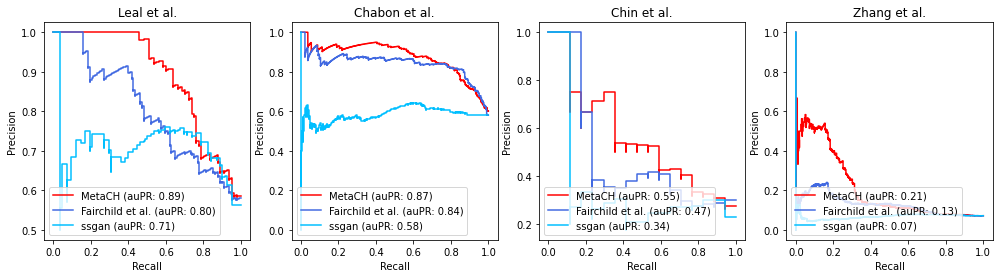

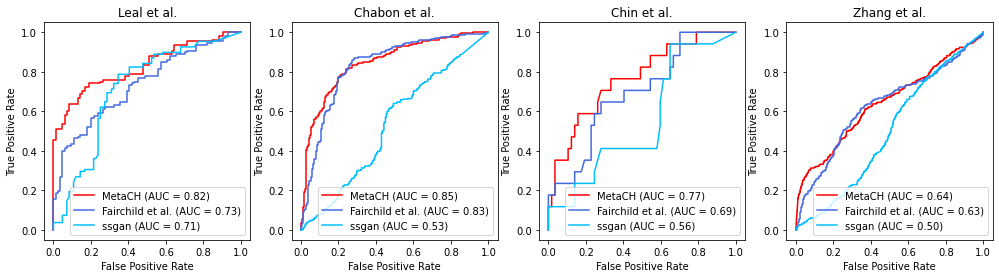

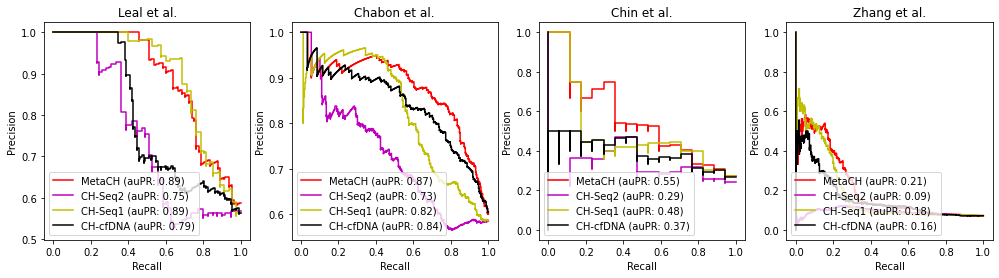

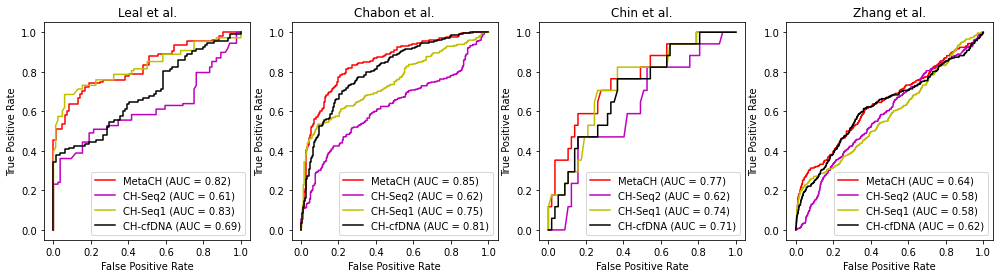

In [13]:
model_info_dict = config['models']

# === Result Tables and Figures ===
results_df = pd.DataFrame(index=dataset_names)
results_df_2 = pd.DataFrame(index=dataset_names)

figs = {
    'pr': plt.subplots(1, 4, figsize=(17, 4))[1],
    'roc': plt.subplots(1, 4, figsize=(17, 4))[1],
    'pr_all': plt.subplots(1, 4, figsize=(17, 4))[1],
    'roc_all': plt.subplots(1, 4, figsize=(17, 4))[1]
}

# === Main Processing Loop ===
dataset_names=['Leal','Chabon', 'Chin','Zhang']
dataset_tables=[leal_dataset,chabon_dataset,chin_dataset, zhang_dataset]
for idx, (name, table) in enumerate(zip(dataset_names, dataset_tables)):

    vectors, features, metadata = mutation_features_dict[name]

    df = pd.concat([metadata, pd.DataFrame(vectors, columns=features)], axis=1)


    df['ssgan_scores'] = table['ssgan_scores']
    sample_id = 'Sample_ID'

    for patt in ['dg_', 'ge_']:
        pt_features = add_patient_level_features(df, sample_id, patt)
        df = pd.merge(df, pt_features, left_on=sample_id, right_on=f"pt_{sample_id}", how='left')

    classifier, _, ctdna_feats =pickle.load(open(model_info_dict[model2use]['classifier_ctdna'], "rb"))
    
    df['CH_cfdna'] = classifier.predict_proba(df[ctdna_feats])[:, 0]
    
    prod_Seq1, ch_seq1_features = pickle.load(open(model_info_dict[model2use]['classifier_Seq1'], "rb"))
    prod_Seq2, ch_seq2_features = pickle.load(open(model_info_dict[model2use]['classifier_Seq2'], "rb"))
    
    df['CH_seq1'] = prod_Seq1.predict_proba(df[ch_seq1_features])[:, 0]
    df['CH_seq2'] = prod_Seq2.predict_proba(df[ch_seq2_features])[:, 0]

    meta_clf, meta_feats = pickle.load(open(model_info_dict[model2use]['metaClassifier'], "rb"))
    df['CH_AZ_1'] = meta_clf.predict_proba(df[meta_feats])[:, 0]

    print(f"{name}: {df.shape[0]} rows")
    print("Label distribution:", Counter(df['label']))

    # === Evaluation ===
    threshold = 0.5
    pred_labels = np.where(df['CH_AZ_1'] > threshold, 'Blood', 'Tumor')
    precision = metrics.precision_score(df['label'], pred_labels, pos_label='Blood')
    recall = metrics.recall_score(df['label'], pred_labels, pos_label='Blood')
    f1 = metrics.f1_score(df['label'], pred_labels, pos_label='Blood')

    # Store results
    _, pr_auc = pr_curve(df['label'], df['CH_AZ_1'], 'Blood', 'MetaCH')
    _, roc_auc = roc_curve(df['label'], df['CH_AZ_1'], 'Blood', 'MetaCH')
    results_df.loc[name, ['auROC(AZ)', 'auPR(AZ)']] = roc_auc, pr_auc
    results_df_2.loc[name, ['auROC(AZ)', 'auPR(AZ)', 'precision(AZ)', 'recall(AZ)', 'F1(AZ)']] = \
        roc_auc, pr_auc, precision, recall, f1

    # === Plotting ===

    for fig_key, func in zip(['pr', 'roc'], [pr_curve, roc_curve]):
        disp, _ = func(df['label'], df['CH_AZ_1'], 'Blood', 'MetaCH');
        disp.plot(ax=figs[fig_key][idx], color='r');
        figs[fig_key][idx].set_title(f"{name} et al.");

    # Baseline comparison
    for color, label, col in zip(['royalblue', 'deepskyblue'], ['Fairchild et al.', 'ssgan'], ['chip_log_pred_prob.wbc', 'ssgan_scores']):
        if col not in df.columns:
            continue
        valid_idx = df[col].notna()
        scores = df.loc[valid_idx, col]
        labels = df.loc[valid_idx, 'label']
        pred = np.where(scores > 0.5, 'Blood', 'Tumor')

        pr_disp, pr_auc_b = pr_curve(labels, scores, 'Blood', label);
        roc_disp, roc_auc_b = roc_curve(labels, scores, 'Blood', label);
        pr_disp.plot(ax=figs['pr'][idx], color=color);
        roc_disp.plot(ax=figs['roc'][idx], color=color);

        p = metrics.precision_score(labels, pred, pos_label='Blood')
        r = metrics.recall_score(labels, pred, pos_label='Blood')
        f = metrics.f1_score(labels, pred, pos_label='Blood')

        results_df.loc[name, [f'auROC-{label}', f'auPR-{label}']] = roc_auc_b, pr_auc_b
        results_df_2.loc[name, [f'auROC-{label}', f'auPR-{label}', f'precision-{label}', f'recall-{label}', f'F1-{label}']] = \
            roc_auc_b, pr_auc_b, p, r, f

    # === Additional CH model comparison plots (fig4a)
    for label, color, col in [
        ('MetaCH', 'r', 'CH_AZ_1'),
        ('CH-Seq2', 'm', 'CH_seq2'),
        ('CH-Seq1', 'y', 'CH_seq1'),
        ('CH-cfDNA', 'k', 'CH_cfdna')]:

        pr_disp, _ = pr_curve(df['label'], df[col], 'Blood', label);
        pr_disp.plot(ax=figs['pr_all'][idx], color=color);
        roc_disp, _ = roc_curve(df['label'], df[col], 'Blood', label);
        roc_disp.plot(ax=figs['roc_all'][idx], color=color);

    figs['pr_all'][idx].set_title(f"{name} et al.");
    figs['roc_all'][idx].set_title(f"{name} et al.");

# === Save Figures ===

# figs['pr'][0].figure.savefig("fig4b_pr_rev0.svg", format="svg", transparent=True)
# figs['roc'][0].figure.savefig("fig4b_roc_rev0.svg", format="svg", transparent=True)
# figs['pr_all'][0].figure.savefig("fig4a_pr_rev0.svg", format="svg", transparent=True)
# figs['roc_all'][0].figure.savefig("fig4a_roc_rev0.svg", format="svg", transparent=True)

# === Output Final Results ===

print(results_df)